# Pruning deep neural networks - tensorflow
### Alex Fang

In [4]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  

### Generate simulation data###

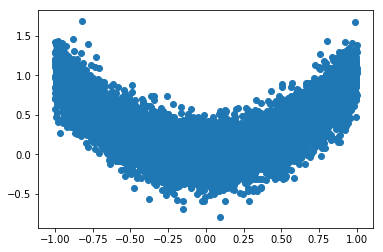

In [27]:
#simulation data========================
x = np.linspace(-1, 1, 10000)[:, np.newaxis]
noise = np.random.normal(0, 0.2, size=x.shape)
y = np.power(x,2) + noise  
mask=np.array([1,0,1,1,0])
plt.scatter(x,y)

### Fully connected layer###

In [17]:
#define one layer
def dense_layer1(inputs,name,units,w,mask,activation=None,use_bias=True,kernel_initializer=None):
        """Mimics tf.dense_layer but masks weights and uses presets as necessary."""
        # If there is a preset for this layer, use it.
        kernel_initializer = tf.constant_initializer(w)
        # Create the weights.
        weights = tf.get_variable(
            name=name + '_w',
            shape=[inputs.shape[1], units],
            initializer=kernel_initializer)
    
        # Mask the layer as necessary.
        mask_initializer = tf.constant_initializer(mask)
        mask = tf.get_variable(
              name=name + '_m',
              shape=[inputs.shape[1], units],
              initializer=mask_initializer,
              trainable=False)
        weights = tf.multiply(weights, mask)
        # Compute the output.
        output = tf.matmul(inputs, weights)
    
        # Add bias if applicable.
        if use_bias:
          bias = tf.get_variable(
              name=name + '_b', shape=[units], initializer=tf.zeros_initializer())
          output += bias
    
        # Activate.
        if activation:
          return activation(output),weights
        else:
          return output,weights

In [40]:
#define one layer
def dense_layer2(inputs,name,units,w,mask,activation=None,use_bias=True,kernel_initializer=None):
        """Mimics tf.dense_layer but masks weights and uses presets as necessary."""
        # If there is a preset for this layer, use it.
        kernel_initializer = tf.constant_initializer(w)
        # Create the weights.
        weights = tf.get_variable(
            name=name + '_w',
            shape=[inputs.shape[1], units],
            initializer=kernel_initializer)
    
        # Mask the layer as necessary.
        mask_initializer = tf.constant_initializer(mask)
        mask = tf.get_variable(
              name=name + '_m',
              shape=[inputs.shape[1], units],
              initializer=mask_initializer,
              trainable=False)
        weights2 = tf.multiply(weights, mask)
        # Compute the output.
        output = tf.matmul(inputs, weights2)
    
        # Add bias if applicable.
        if use_bias:
          bias = tf.get_variable(
              name=name + '_b', shape=[units], initializer=tf.zeros_initializer())
          output += bias
    
        # Activate.
        if activation:
          return activation(output),weights
        else:
          return output,weights

### Experiment1，Experiment2，use 'mask' to stop the back propagation ###

In [29]:
#experiment1
tf.reset_default_graph()
tf_x = tf.placeholder(tf.float32, [None,x.shape[1]])
tf_y = tf.placeholder(tf.int32, [None,1]) 
tf_is_training = tf.placeholder(tf.bool, None)
l1,w1=dense_layer1(tf_x,'l1', 5, np.ones((x.shape[1],5)),mask,activation=tf.nn.relu)
output=tf.layers.dense(l1,1)
loss = tf.losses.mean_squared_error(tf_y, output)
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.5)
train_op = optimizer.minimize(loss)
sess = tf.Session() 
sess.run(tf.global_variables_initializer()) 
for step in range(20):
    # train and net output
    _, loss_, pred,w1_= sess.run([train_op, loss, output,w1], {tf_x: x.reshape(-1,1), tf_y: y.reshape(-1,1)})      
    #print(loss_)
    if (step-1)%5==0:
        print(w1_)

[[0.7655226 0.        0.7596624 0.9823524 0.       ]]
[[0.7621332  0.         0.75474787 0.97082907 0.        ]]
[[0.74887574 0.         0.7401517  0.9740777  0.        ]]
[[0.7452088  0.         0.7353616  0.97423935 0.        ]]


In [30]:
#experiment2
tf.reset_default_graph()
tf_x = tf.placeholder(tf.float32, [None,x.shape[1]])
tf_y = tf.placeholder(tf.int32, [None,1]) 
tf_is_training = tf.placeholder(tf.bool, None)
l1,w1=dense_layer2(tf_x,'l1', 5, np.ones((x.shape[1],5)),mask,activation=tf.nn.relu)
output=tf.layers.dense(l1,1)
loss = tf.losses.mean_squared_error(tf_y, output)
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.5)
train_op = optimizer.minimize(loss)
sess = tf.Session() 
sess.run(tf.global_variables_initializer()) 
for step in range(20):
    # train and net output
    _, loss_, pred,w1_= sess.run([train_op, loss, output,w1], {tf_x: x.reshape(-1,1), tf_y: y.reshape(-1,1)})      
    #print(loss_)
    if (step-1)%5==0:
        print(w1_)

[[0.98648834 1.         1.0061736  1.0049639  1.        ]]
[[0.963877  1.        1.01828   1.0149359 1.       ]]
[[0.9588267 1.        1.0212048 1.0173718 1.       ]]
[[0.9524769 1.        1.0249845 1.0205351 1.       ]]


### About tf.stop_gradient()###

In [39]:
#example
tf.reset_default_graph()

a = tf.Variable(1.0)
b = tf.Variable(1.0)
 
c = tf.add(a, b)
 
c_stoped = tf.stop_gradient(c)
 
d = tf.add(a, b)
 
e = tf.add(c_stoped, d)

gradients_from_c = tf.gradients(c_stoped, xs=[a, b])
gradients_from_d = tf.gradients(e, xs=[a, b])

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    try:
        print(sess.run(gradients_from_c))
    except:
        print("Sth wrong in bp process of C and a,b. ")
    print("========================")
    try:
        print(sess.run(gradients_from_d))
    except:
        print("Sth wrong in bp process of d and a,b. ")

Sth wrong in bp process of C and a,b. 
[1.0, 1.0]


In [47]:
#experiment3
tf.reset_default_graph()

def entry_stop_gradients(target, mask):

    mask_h = tf.abs(mask-1)
    return tf.stop_gradient(mask_h * target) + mask * target
 
mask = np.array([1., 0, 1, 1, 0, 0, 1, 1, 0, 1])
weights = tf.constant(np.ones([10, 5]))
 
matrix = entry_stop_gradients(weights, tf.expand_dims(mask,1))
 
parm = np.random.randn(5, 1)
para = tf.constant(parm)
 
loss = tf.reduce_sum(tf.matmul(matrix, para))
grad1 = tf.gradients(loss, weights)
grad2 = tf.gradients(loss, matrix)


with tf.Session() as sess:
    g1,g2=sess.run([grad1, grad2])
    matrix_=sess.run(matrix)
    print(g1)
    print(g2)
    print(matrix_)
    

[array([[-1.67977959, -1.37421142,  0.75463177, -1.33602353,  1.27111932],
       [-0.        , -0.        ,  0.        , -0.        ,  0.        ],
       [-1.67977959, -1.37421142,  0.75463177, -1.33602353,  1.27111932],
       [-1.67977959, -1.37421142,  0.75463177, -1.33602353,  1.27111932],
       [-0.        , -0.        ,  0.        , -0.        ,  0.        ],
       [-0.        , -0.        ,  0.        , -0.        ,  0.        ],
       [-1.67977959, -1.37421142,  0.75463177, -1.33602353,  1.27111932],
       [-1.67977959, -1.37421142,  0.75463177, -1.33602353,  1.27111932],
       [-0.        , -0.        ,  0.        , -0.        ,  0.        ],
       [-1.67977959, -1.37421142,  0.75463177, -1.33602353,  1.27111932]])]
[array([[-1.67977959, -1.37421142,  0.75463177, -1.33602353,  1.27111932],
       [-1.67977959, -1.37421142,  0.75463177, -1.33602353,  1.27111932],
       [-1.67977959, -1.37421142,  0.75463177, -1.33602353,  1.27111932],
       [-1.67977959, -1.37421142, 

* To sum up, we can use mask to prune the network and stop the pruned parameter to get back propagation. However, if we want some part of the parameter not to be back propagated（these para is larger than 0）, we can use tf.stop_gradient() to meet this demand.